In [10]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as cx


# Read the letters
letters = pd.read_csv('../data/letters.csv',encoding='utf-8')
# group by place and location
places = letters.groupby(['place', 'location']).size().reset_index(name='count')
letters = letters.drop(columns=['location'])
places['place_id'] = places.index + 1
places = places.drop(columns=['count'])

cols = places.columns.tolist()
cols = cols[-1:] + cols[:-1]
places = places[cols]

In [11]:
# parse into geopandas
places["geometry"] = places["location"].str.split(",")

places['geometry'] = places['geometry'].apply(lambda x: x[:-1])

# convert geometry to wkt from [lat,lon] to POINT(lon lat)
places['geometry'] = places['geometry'].apply(lambda x: 'POINT (' + x[1] + ' ' + x[0] + ')')
# geometry to geometry object

places['geometry'] = places['geometry'].apply(wkt.loads)

# convert to geodataframe
gplaces = gpd.GeoDataFrame(places, geometry='geometry')

# remove location col
gplaces = gplaces.drop(columns=['location'])

# rename place to name



In [12]:
gplaces

,place_id,place,geometry
0,1,Angerborg (Węgorzewo),POINT (21.74163 54.21359)
1,2,Arys (Orzysz),POINT (21.9473 53.80989)
2,3,Arys (Orzysz),POINT (21.9473 53.80989)
3,4,Augostov (Augustów),POINT (22.9796 53.84344)
4,5,"Bakkely, Regstrup, Fyn",POINT (10.76257 55.35196)
...,...,...,...
70,71,Vauxtin,POINT (3.60215 49.3502)
71,72,Villeselve,POINT (3.10962 49.69007)
72,73,Vivaise,POINT (3.55993 49.61988)
73,74,Willenberg (Wielbark),POINT (20.94576 53.39815)


In [13]:
# merge places into letters
placed_letters = letters.merge(gplaces[['place','place_id']], on='place',how='left',)
placed_letters.place_id = placed_letters.place_id.fillna(0).astype(int)
placed_letters = placed_letters.drop(columns=['place'])
#placed_letters.value_counts('place_id')

gplaces = gplaces.rename(columns={'place': 'name'})

# save to file
gplaces.to_csv('../data/places.csv', index=False, encoding='utf-8')

# write to csv
placed_letters.to_csv('../data/placed_letters.csv', index=False)


## clean up steps

In [14]:
import requests

def get_lat_lon(p):
    point = p.centroid
    return point.y, point.x


# Add OSM and Google Maps links
gplaces['lat_lon'] = gplaces['geometry'].apply(get_lat_lon)
gplaces['osm_link'] = gplaces['lat_lon'].apply(lambda x: f"https://www.openstreetmap.org/?mlat={x[0]}&mlon={x[1]}&zoom=12")
gplaces['google_maps_link'] = gplaces['lat_lon'].apply(lambda x: f"https://www.google.com/maps/?q={x[0]},{x[1]}")

def reverse_geocode(lat_lon):
    base_url = "https://nominatim.openstreetmap.org/reverse"
    params = {
        'format': 'jsonv2',
        'lat': lat_lon[0],
        'lon': lat_lon[1]
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data.get('address', {}).get('city', 'Unknown')
    else:
        return 'Error'

# Add closest city name
# gplaces['closest_city'] = gplaces['lat_lon'].apply(reverse_geocode)

# Drop the lat_lon column if it's not needed
gplaces.drop(columns=['lat_lon'], inplace=True)

# Save to CSV


In [15]:
gplaces

,place_id,name,geometry,osm_link,google_maps_link
0,1,Angerborg (Węgorzewo),POINT (21.74163 54.21359),https://www.openstreetmap.org/?mlat=54.21359&m...,"https://www.google.com/maps/?q=54.21359,21.741..."
1,2,Arys (Orzysz),POINT (21.9473 53.80989),https://www.openstreetmap.org/?mlat=53.80989&m...,"https://www.google.com/maps/?q=53.80989,21.9473"
2,3,Arys (Orzysz),POINT (21.9473 53.80989),https://www.openstreetmap.org/?mlat=53.80989&m...,"https://www.google.com/maps/?q=53.80989,21.9473"
3,4,Augostov (Augustów),POINT (22.9796 53.84344),https://www.openstreetmap.org/?mlat=53.8434431...,"https://www.google.com/maps/?q=53.8434431,22.9..."
4,5,"Bakkely, Regstrup, Fyn",POINT (10.76257 55.35196),https://www.openstreetmap.org/?mlat=55.3519638...,https://www.google.com/maps/?q=55.351963874999...
...,...,...,...,...,...
70,71,Vauxtin,POINT (3.60215 49.3502),https://www.openstreetmap.org/?mlat=49.3501987...,"https://www.google.com/maps/?q=49.3501987,3.60..."
71,72,Villeselve,POINT (3.10962 49.69007),https://www.openstreetmap.org/?mlat=49.6900681...,"https://www.google.com/maps/?q=49.6900681,3.10..."
72,73,Vivaise,POINT (3.55993 49.61988),https://www.openstreetmap.org/?mlat=49.6198789...,"https://www.google.com/maps/?q=49.6198789,3.55..."
73,74,Willenberg (Wielbark),POINT (20.94576 53.39815),https://www.openstreetmap.org/?mlat=53.3981483...,"https://www.google.com/maps/?q=53.3981483,20.9..."


In [16]:
gdf1914world = gpd.read_file('../maps/1914/1914.geojson')
# remove the world outside 
ylim=(43,60)
xlim=(-3,40)

# remove countries outside the map
gdf1914 = gdf1914world.cx[xlim[0]:xlim[1], ylim[0]:ylim[1]]


danish_countries = [
    'Belgien', 'Bulgarien', 'Schweiz', 'Danmark', 'Finland', 'Frankrig', 
    'Guernsey', 'Italien', 'Jersey', 'Liechtenstein', 'Luxembourg', 
    'Montenegro', 'Holland', 'Norge', 'San Marino', 'Serbien', 
    'Sverige', 'Rumænien', 'Østrig-Ungarn', 'Storbritannien', 
    'Tyskland', 'Den Russiske Føderation', 'Monaco', 'Spanien'
]

skip_countries = [
    'Guernsey','Liechtenstein', 'Luxembourg', 'San Marino','Monaco', 'Jersey','Danmark'
    ,'Storbritannien','Frankrig','Tyskland','Østrig-Ungarn',
]

# English names of the countries
english_countries = [
    'Belgium', 'Bulgaria', 'Switzerland', 'Denmark', 'Finland', 'France', 
    'Guernsey', 'Italy', 'Jersey', 'Liechtenstein', 'Luxembourg', 
    'Montenegro', 'Netherlands', 'Norway', 'San Marino', 'Serbia', 
    'Sweden', 'Rumania', 'Austria - Hungary ', 'United Kingdom', 
    'Germany', 'Russian Federation', 'Monaco', 'Spain'
]

# Function to replace English country names with Danish names in a GeoPandas DataFrame
def replace_country_names(df, column_name='NAME'):
    translation_map = dict(zip(english_countries, danish_countries))
    df[column_name] = df[column_name].map(translation_map).fillna(df[column_name])

replace_country_names(gdf1914)



d:\projects\dalager\2_areas\jernkorsetbreve\.venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# given the geometry column of gplaces the geodataframe gdf1914, add a country column to gplaces with country name
# use a spatial join to find the country of each place
# Perform spatial join between gplaces and gdf1914
gplaces = gpd.sjoin(gplaces, gdf1914[['NAME', 'geometry']], how='left', predicate='within')

# Rename NAME to country
gplaces = gplaces.rename(columns={'NAME': 'country'})

# Fill any missing countries (points that didn't fall within any polygon)
gplaces['country'] = gplaces['country'].fillna('Unknown')

# drop index_right 
gplaces = gplaces.drop(columns=['index_right'])

# Save updated places to CSV
gplaces.to_csv('../data/places_cleanup.csv', index=False, encoding='utf-8')

C:\Users\christian.dalager\AppData\Local\Temp\ipykernel_20332\3706521082.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gplaces = gpd.sjoin(gplaces, gdf1914[['NAME', 'geometry']], how='left', predicate='within')


<Axes: >

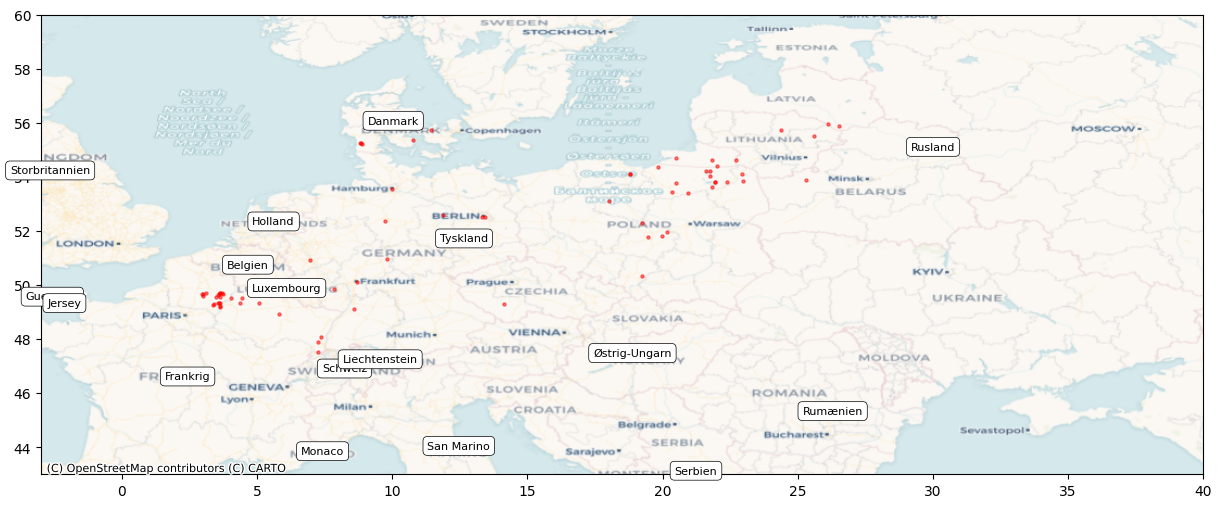

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))



ax.set_ylim(43, 60)
ax.set_xlim(-3, 40)
#gdf1914.plot(ax=ax, cmap="tab20c", edgecolor="black", alpha=0.5)
gdf1914.apply(
    lambda x: ax.annotate(
        x.NAME,
        xy=x.geometry.centroid.coords[0],
        ha="center",
        size=8,
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),
    ),
    axis=1,
)
ax.annotate(
    "Rusland",
    xy=(30, 55),
    ha="center",
    size=8,
    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.5),
)

cx.add_basemap(ax, crs="epsg:4326", source=cx.providers.CartoDB.Voyager)
gplaces.plot(ax=ax, edgecolor="red", markersize=5, alpha=0.5, color="red")